# flashing_lights.GenerateHeatMap() Example Notebook

* This function is used to generate an accumulation of frequency counts for single pixels throughout the duration of an image stack. It is a particularly useful function for researchers presenting qualititative information from fluorescence microscopy videos, such as the relative fluorescent activity for different regions of the image, or comparison of spatial features between multiple videos. 

* Typical video formats include .mp4 and .tif; video format must be supported by opencv to be input correctly for this function

### Part 1 - Importing Necessary Modules

* For the code to run properly, we require a stack of modules that are available within the flashing_lights_env virtual environment.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from GenerateHeatMap import GetFreqCounts
from GenerateHeatMap import GetFreqArray
from GenerateHeatMap import Heatmap

### Part 2 - Loading Video Files to Use

In [4]:
test_video1 = '/Users/mcalli75/Desktop/NP_collision_array.tif'
test_video2 = '/Users/mcalli75/Desktop/NP_collision_array_2.tif'

The above videos are of single molecule reaction events taking place on a microelectrode array. Reaction counts register as light which is captured within the microscope images. We hope to accumulate the frequency of light generating events to produce a heatmap which qualitatively describes the activity of our array surface. 

### Part 3 - Obtaining Frequency Counts of a Single Image
* To accumulate the frequency of brightness events within a video, we first need a function which can obtain the coordinates of pixels where events occur in each frame. To do this, we created a function that searches through a frame for pixels brighter than a given threshold, then stores a frequency value of 1 in the location of the event. Pixels with brightness values below the threshold are ignored. 
* Here is the code:

``` 
def GetFreqCounts(frame, threshold):
    """Searches through an image to find greyscale pixels above a certain
    brightness threshold. If counts of sufficient brightness are present
    within the image, a frequency counter of 1 is added to an empty array.

    Inputs:

    - frame: ndarray of pixels (image file or video frame)
    - threshold: minimum brightness for an event detection

    Output: an ndarray of boolean values describing which
    pixels were above the brightness threshold in the frame

    """
    # Generating empty matrix for coordinate assignment
    frequency = np.zeros((len(frame), len(frame)))
    # Generating index lists to keep track of ROI coordinates
    index_count_row = []
    index_count_col = []
    # Looks through matrix for points above a brightness threshold
    if len(np.where(frame == threshold)) > 0:
        # Finding coordinates of brightness events
        row, col = np.where(frame >= threshold)
        for i in range(len(row)):
            for j in range(len(col)):
                # Adds intensity value in the position of the
                # given brightness event
                frequency[row[i], col[j]] = frame[row[i], col[j]]
                # Adds a value of 1 to the frequency output in the position of
                # the given brightness event
                frequency[row[i], col[i]] = 1
                index_count_row.append(row[i])
                index_count_col.append(col[j])
    else:
        pass
    return frequency
    ```

**To run the code we just need a video file, for now we will set the brightness threshold as 1**

In [6]:
# Reading in video file to use in code
ret, img = cv2.imreadmulti(test_video1, flags = cv2.IMREAD_GRAYSCALE)

In [7]:
# Performing function on first frame of video
freq_counts = GetFreqCounts(img[0], 1)

In [13]:
# Finding where events occurred  
row, col = np.where(freq_counts == 1)
count_coord = pd.DataFrame({'X':row, 'Y': col})
count_coord

,X,Y
0,17,321
1,18,384
2,19,251
3,20,303
4,21,249
...,...,...
236,471,144
237,473,423
238,477,384
239,503,204


So based on our threshold, 241 brightness events occurred, and our function allows us to quickly determine the coordinates of each point.

### Part 4 - Accumulating Frequency Counts Across Entire Image Stack
* Since our first function can pull out event coordinates in a single image, we need a function which can iterate through each frame in the video, storing an additional frequency count for every time a pixel lights up. From the output of this function, we can map our accumulated frequencies over a blank image to produce a heatmap
* Here is the code:

```
def GetFreqArray(videofile, threshold, scale_percent, outliers=True):
    """Finds pixel coordinates within a videofile (.tif, .mp4) for pixels
    that are above a calculated brightness threshold, then accumulates the
    brightness event count for each coordinate,
    outputting it as a 2-D array in the same size as the video frames

    Input:
    -videofile: file containing an image stack of fluorescent events
    -threshold: minimum brightness value for event detection
    -scale_percent: size of image you would like to resize to (% value)
    -outliers: If True, tests for outliers in the data

    Output: 2-d Array of frequency values for each pixel above
    a calculated brightness threshold in the video"""
    # Reading video file and convert to grayscale
    ret, img = cv2.imreadmulti(videofile, flags=cv2.IMREAD_GRAYSCALE)
    # Setting Resizing Dimensions
    width = int(img[0].shape[1] * scale_percent / 100)
    height = int(img[0].shape[0] * scale_percent / 100)
    dim = (width, height)
    img_resized = cv2.resize(img[0], dim, interpolation=cv2.INTER_AREA)
    # Creating empty array to add intensity values to
    freq_array = np.zeros(np.shape(img_resized))
    # Looking through each frame to get the frequency counts
    for frame in range(len(img)):
        # Resize Frame
        frame_resized = cv2.resize(img[frame],
                                   dim, interpolation=cv2.INTER_AREA)
        freq = GetFreqCounts(frame_resized, threshold)
        if len(np.where(freq == 1)) > 0:
            # Get coordinates of the single pixel counts
            row, col = np.where(freq == 1)
            for i in range(len(row)):
                for j in range(len(col)):
                    # Add single count to freq_array in location of event
                    freq_array[row[i], col[j]] += 1
        else:
            pass
    if outliers is True:
        # Videos may contain points with extremely high frequency
        # relative to other pixels. This can affect the quality
        # of the heatmap produced. So, this part of the code determines a
        # max frequency from the freq distribution, then sets all points above
        # the max frequency to the max frequency.
        # This is solely for heatmap quality, it can be commented out.
        #
        # Creating empty frequency list for determining outliers
        freq_list = []
        # finding points where the frequency is greater than 0
        freq_row, freq_col = np.where(freq_array >= 1)
        for i in range(len(freq_row)):
            # Appending frequency values above 0 to freq_list
            freq_list.append(freq_array[freq_row[i], freq_col[i]])
        # Sorting the list to calculate its distribution
        sort_list = sorted(freq_list)
        # Calculating the distribution
        q1, q3 = np.percentile(sort_list, 25), np.percentile(sort_list, 75)
        iqr = q3 - q1
        upper_lim = q3 + 1.5*iqr
        # Finding Outliers
        if len(np.where(freq_array >= upper_lim)) > 0:
            outlier_row, outlier_col = np.where(freq_array >= upper_lim)
            for i in range(len(outlier_row)):
                for j in range(len(outlier_col)):
                    # Replacing outlier frequency with upper limit
                    freq_array[outlier_row[i], outlier_col[j]] = upper_lim
        else:
            pass
    else:
        pass
    return freq_array

```

* **This code is much longer and more complicated than the last**
* **The scale_percent variable is used to reduce image sizes for faster processing speeds**
* **There is a part of the function which determines outliers from the distribution of frequency values; this serves to enhance the quality of the heatmap produced for these particular images.**

In [15]:
x = GetFreqArray(test_video1, 1, 100)

In [19]:
x

array([[0. , 0. , 0. , ..., 3.5, 3.5, 2. ],
       [0. , 1. , 0. , ..., 3.5, 3.5, 3.5],
       [0. , 0. , 0. , ..., 0. , 1. , 3.5],
       ...,
       [0. , 1. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ]])

In [18]:
np.shape(x)

(512, 512)

The output of the function is an array of float values in the shape of the input image. This will easily map onto an array to produce a heatmap

### Part 5 - Generating the Heat Map
* Now that we have an array of frequency values, we just need to map them onto a blank image to get our heatmap. 
* Here is the code:

```
def Heatmap(videofile, threshold, scale_percent, img_path, img_name,
            outliers=True):
    """Takes frequency accumulation array from
    GenerateHeatMap.GetFreqArray() and plots it as
    a colored meshgrid.

    Yellow pixels are at max frequency, blue pixels are
    minimum frequency (cmap = 'plasma')"""
    # Reading video file
    ret, img = cv2.imreadmulti(videofile, flags=cv2.IMREAD_GRAYSCALE)
    # obtaining frequency array
    if outliers is True:
        z = GetFreqArray(videofile, threshold, scale_percent)
    else:
        z = GetFreqArray(videofile, threshold, scale_percent, outliers=False)
    # Generating x and y axes in shape of image frame
    width = int(img[0].shape[1] * scale_percent / 100)
    height = int(img[0].shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    frame_resized = cv2.resize(img[0], dim, interpolation=cv2.INTER_AREA)
    pixel_X = np.arange(0, frame_resized.shape[1])
    pixel_Y = np.arange(0, frame_resized.shape[0])
    # Mapping frequency array onto the x and y axes
    fig = plt.pcolormesh(pixel_X, pixel_Y, z, cmap='plasma')
    plt.xlabel('Pixel Count')
    plt.ylabel('Pixel Count')
    plt.title('Frequency Heat Map')
    # picture is saved in file location designated by user
    plt.savefig(img_path + '/' + img_name + '.png', bbox_inches='tight')
    return fig

```

**To run this code we just need a video file, a directory to save it to, and a name for the output image**
* The plt. variables can be modified for plot title, axis titles, etc.
* In the following examples, the file is saved to the current working directory

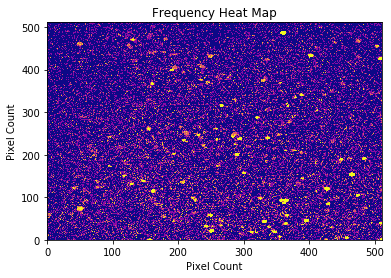

In [20]:
Heatmap(test_video1, 1, 100, '.', 'freq_acc_map_ex')

In the image above, blue regions are where no fluorescence occurs, while pink and yellow regions are where events do occur. Yellow pixels represent pixels at or above the upper limit of the frequency distribution. 

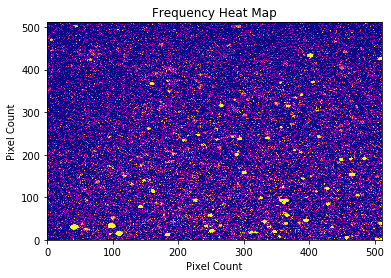

In [21]:
Heatmap(test_video2, 1, 100, '.', 'freq_acc_map_ex2')